# 0. Import Necessary Modules

In [63]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE,ADASYN
from imblearn.combine import SMOTEENN
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [3]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
matplotlib.rc('font', **font)

In [4]:
from sklearn.metrics import average_precision_score

In [5]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as st

# 1. Data I/O

In [6]:
data=pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# 2. Data Exploration

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [8]:
data['Class'].value_counts() # Heavily Skewed

0    284315
1       492
Name: Class, dtype: int64

In [9]:
data['Class']=data['Class'].map({1:'Fraud',0:'Normal'})

/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


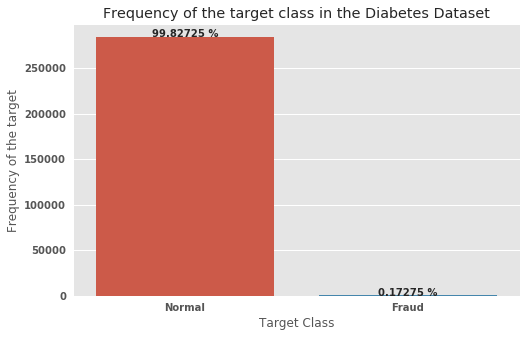

In [10]:
import matplotlib.style as style
style.use('ggplot')
plt.figure(figsize=(8,5))
ax=sns.countplot(x='Class', data=data);
total=float(len(data))
plt.title('Frequency of the target class in the Diabetes Dataset')
plt.ylabel('Frequency of the target')
plt.xlabel('Target Class')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.5f} %'.format(height*100/total),ha="center")

In [11]:
#sns.pairplot(data, hue="Outcome",diag_kind="kde")

/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


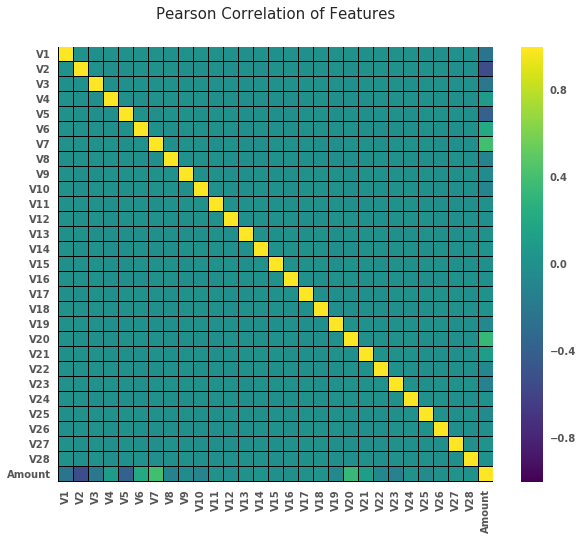

In [12]:
data_num=data.drop(['Time','Class'],axis=1)
colormap = plt.cm.viridis
plt.figure(figsize=(10,8))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(data_num.astype(float).corr(),linewidths=0.05,vmax=1.0, square=True, cmap=colormap, linecolor='black', annot=False);

# 3. Data preprocessing

In [13]:
X=data.drop(['Time','Class'],axis=1)
Y=data[['Class']]
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=0,stratify=Y.Class)

In [14]:
X_train['Amount']=StandardScaler().fit_transform(X_train['Amount'].values.reshape(-1, 1))
X_test['Amount']=StandardScaler().fit_transform(X_test['Amount'].values.reshape(-1, 1))

/home/namanda/anaconda3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/namanda/anaconda3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
159810,-0.213791,0.827086,0.476312,0.324509,0.682825,0.738069,0.635548,0.020445,0.601290,-0.392651,...,-0.224666,-0.452713,-1.168484,0.154762,-0.039586,-0.434352,-1.206826,-0.299128,0.035932,-0.212896
78456,1.108114,0.076161,0.180980,0.747022,-0.422557,-1.096108,0.327595,-0.144312,-0.023643,-0.063789,...,-0.159342,-0.306208,-1.060680,0.214553,0.549775,0.097760,0.029681,-0.057002,0.017881,-0.140177
159663,0.054750,0.929015,0.253177,-0.628441,0.568255,-1.024227,1.064345,-0.249808,-0.173203,-0.436210,...,0.023266,-0.260095,-0.523044,0.037893,-0.091845,-0.438712,0.144389,0.253354,0.097885,-0.339036
6517,-0.318601,1.130156,1.761166,1.423952,0.225281,-0.320472,0.509444,-0.114489,0.477863,-0.527181,...,0.001433,0.100244,0.640482,-0.116636,0.363731,-0.315616,-0.248976,0.162759,0.150523,-0.320288
11579,1.410336,-0.625361,0.289247,-0.541446,-0.717432,-0.018733,-0.871735,0.040156,0.880404,0.337488,...,-0.062141,-0.192763,-0.324472,-0.117071,-0.574782,0.560330,-0.243539,-0.028145,-0.015180,-0.306834


In [16]:
X_test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
175371,-0.333572,-0.260711,-0.444573,-1.269694,-0.722845,1.026726,1.714035,-0.224337,-1.230857,0.171356,...,-0.495949,-0.136521,0.299618,0.194141,0.229860,-0.661863,0.261762,0.207698,0.137946,1.005159
240914,1.919125,-0.483016,-0.175210,0.443473,-0.841282,-0.355453,-0.712288,0.090086,1.242635,0.009596,...,-0.224362,0.250701,0.925525,0.118774,0.095816,-0.149623,-0.237904,0.035786,-0.045510,-0.317212
274643,0.036437,1.363662,-1.193580,0.105581,0.353584,-1.153817,0.544680,0.178014,-0.104319,-0.516363,...,-0.080112,-0.064618,-0.087809,0.566757,1.059573,-2.270369,-0.078836,0.330675,0.393533,-0.359232
242546,2.056321,-1.829648,-0.732793,-1.353940,-1.765126,-0.863630,-1.139042,-0.204751,-0.924425,1.523665,...,-0.249274,-0.086128,-0.013440,0.159245,-0.059305,-0.344454,-0.184234,-0.000413,-0.026384,0.181869
253876,0.086220,0.625644,1.838501,1.073470,-0.306243,0.022964,0.266889,-0.250856,0.119789,-0.003614,...,0.379927,0.316322,1.399831,-0.355504,0.137635,-0.239085,0.285450,0.070170,-0.059021,-0.308825


In [17]:
# mapping back
Y_train['Class']=Y_train['Class'].map({'Fraud':1,'Normal':0})
Y_test['Class']=Y_test['Class'].map({'Fraud':1,'Normal':0})

/home/namanda/anaconda3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/namanda/anaconda3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
#Y_train.values

In [19]:
# already Principal components
X_train_pca=X_train[['V1','V2','V3','V4','V5']]

In [20]:
X_train_pca['Class']=Y_train

/home/namanda/anaconda3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


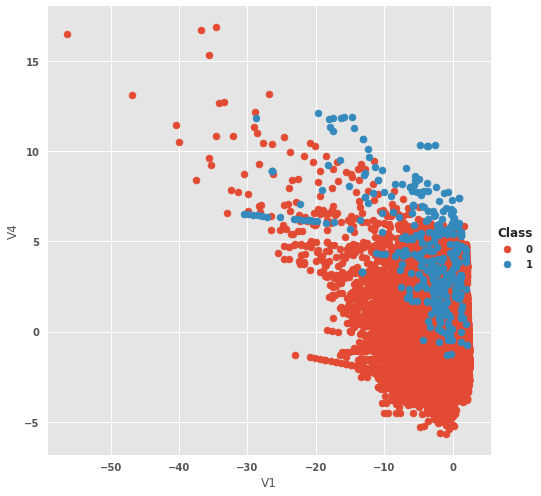

In [21]:
sns.FacetGrid(X_train_pca, hue="Class", size=7).map(plt.scatter, "V1", "V4").add_legend()

# 4. Model Building

# 4.0 Utility Functions

In [22]:
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'}
axis_font = {'fontname':'Arial', 'size':'16'}

In [23]:
import itertools

def plot_confusion_matrix(axd,cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.sca(axd)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        1#print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",size=16)
    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [81]:
def model_fitting_and_post_processing(clf,X_train,Y_train,X_test,Y_test,clf_name='SVM',class_names=[0,1],cross_val=False):
    #average precision for the precision recall curves
    # passing dataframes into the function
    clf.fit(X_train.values,Y_train.values.ravel())
    #print(clf.best_estimator_)
    if cross_val:
        clf=clf.best_estimator_
        print('\n')
        print(clf)
        print('\n')
    predictions=clf.predict(X_test.values)
    #decision function
    try:
        Y_score = clf.decision_function(X_test.values)
    except:
        Y_score = clf.predict_proba(X_test.values)[:,1]
    #Y_score=clf.decision_function(X_test.values)
    # printing the accuracy
    print('The accruacy of %s on the Test set: '%clf_name, accuracy_score(Y_test.values,predictions))
    # predicting probabilities
    post_probab_predictions=clf.predict_proba(X_test.values)
    # assiging the probability
    post_probab_predictions=post_probab_predictions[:,1]
    # now subplotting
    fig, axes=plt.subplots(2,2,figsize=(14,10))
    # Class Distribution
    plt.sca(axes[0,0])
    data_train=X_train.copy()
    data_train['Class']=Y_train.values
    data_train['Class']=data_train['Class'].map({1.0:'Fraud',0.0:'Normal'})
    ax=sns.countplot(x='Class', data=data_train);
    total=float(len(data_train))
    plt.title('Frequency of the target class in the Training-set',**title_font)
    plt.ylabel('Frequency of the target',**axis_font)
    plt.xlabel('Target Class',**axis_font)

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.5f} %'.format(height*100/total),ha="center")
        #ax.text(p.get_x()+p.get_width()/2.,height - 35,'{:1.5f} '.format(height),ha="center")
    
    # Confusion Matrix
    cnf_matrix = confusion_matrix(Y_test.values,predictions)
    np.set_printoptions(precision=2)
    plot_confusion_matrix(axes[0,1],cnf_matrix, classes=class_names, title='Confusion matrix')
    axes[0,1].grid('off')

    # ROC CURVE
    fpr, tpr, thresholds = roc_curve(Y_test.values.ravel(),post_probab_predictions.ravel())
    roc_auc = auc(fpr,tpr)
    plt.style.use('ggplot')
    title_gp='ROC for '+clf_name+' Classifier'
    axes[1,0].set_title(title_gp)
    axes[1,0].plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
    axes[1,0].legend(loc='lower right')
    axes[1,0].plot([0,1],[0,1],'r--')
    axes[1,0].set_ylabel('True Positive Rate',**axis_font)
    axes[1,0].set_xlabel('False Positive Rate',**axis_font)
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(Y_test.values.ravel(), Y_score)
    average_precision = average_precision_score(Y_test.values.ravel(), Y_score)
    axes[1,1].step(recall, precision, color='red', alpha=0.2,where='post',label='Average Precision = %0.2f'%average_precision)
    axes[1,1].fill_between(recall, precision, step='post', alpha=0.2,color='b')
    axes[1,1].legend(loc='lower right')
    axes[1,1].set_xlabel('Recall',**axis_font)
    axes[1,1].set_ylabel('Precision',**axis_font)
    title_gp='Precision-Recall Curve for '+clf_name+' Classifier'
    axes[1,1].set_title(title_gp)


    fig.tight_layout()
    print('\n')
    print('----------------------- Complete Classification Report -----------------------\n')
    print(classification_report(Y_test.values,predictions))
    print('\n')
    print('--------------------------- Post-processed Plots --------------------------\n')    
    return predictions

The accruacy of Logistic Reg on the Test set:  0.9991456292499094


/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))




----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85295
          1       0.86      0.61      0.71       148

avg / total       1.00      1.00      1.00     85443



--------------------------- Post-processed Plots --------------------------



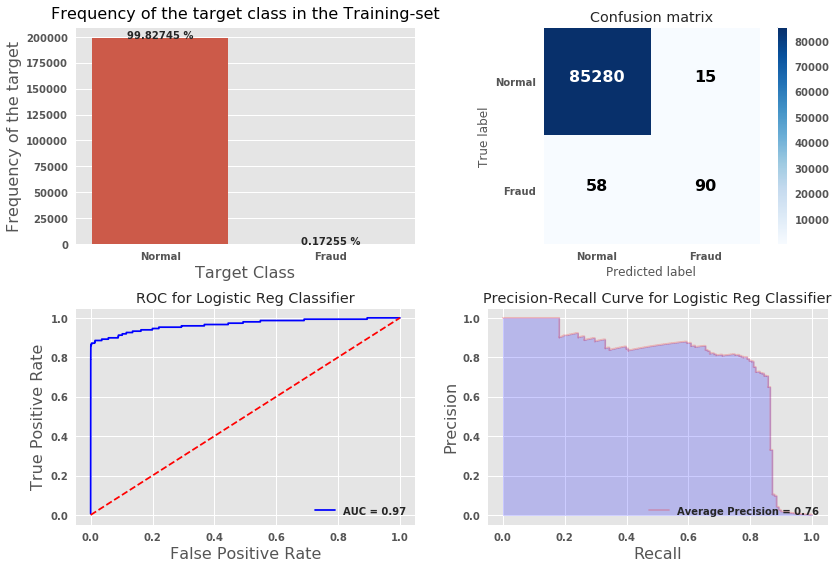

In [25]:
from sklearn.linear_model import LogisticRegression
clf_log=LogisticRegression()
pred_log=model_fitting_and_post_processing(clf_log,X_train,Y_train,X_test,Y_test,clf_name='Logistic Reg',class_names=['Normal','Fraud'])

# 4.1 Using SVM without Imbalanced learning approach

The accruacy of SVM on the Test set:  0.9993328885923949


/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))




----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85295
          1       0.98      0.63      0.77       148

avg / total       1.00      1.00      1.00     85443



--------------------------- Post-processed Plots --------------------------



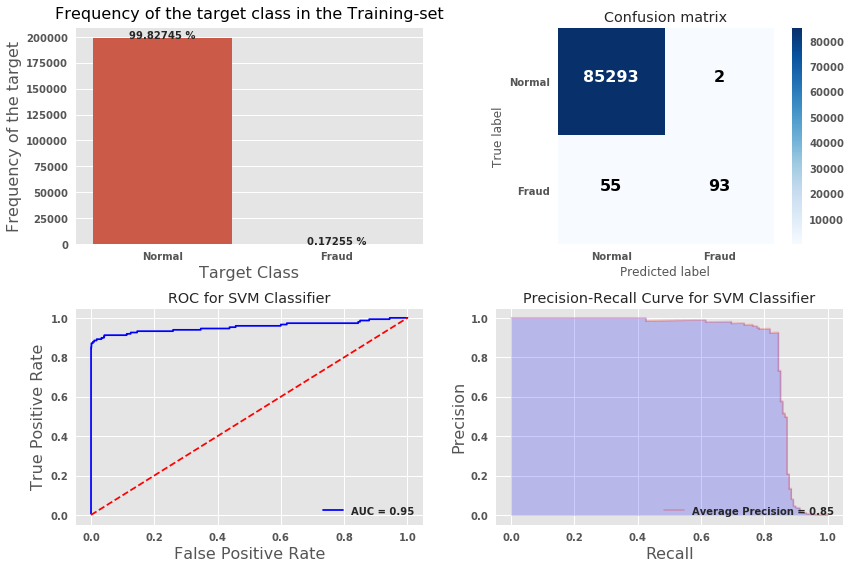

In [26]:
clf_svm=SVC(kernel='rbf',probability=True)
preds_svm=model_fitting_and_post_processing(clf_svm,X_train,Y_train,X_test,Y_test,clf_name='SVM',class_names=['Normal','Fraud'])

# 4.2 Random Forests

The accruacy of Random Forests on the Test set:  0.9994850368081645


/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))




----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85295
          1       0.96      0.73      0.83       148

avg / total       1.00      1.00      1.00     85443



--------------------------- Post-processed Plots --------------------------



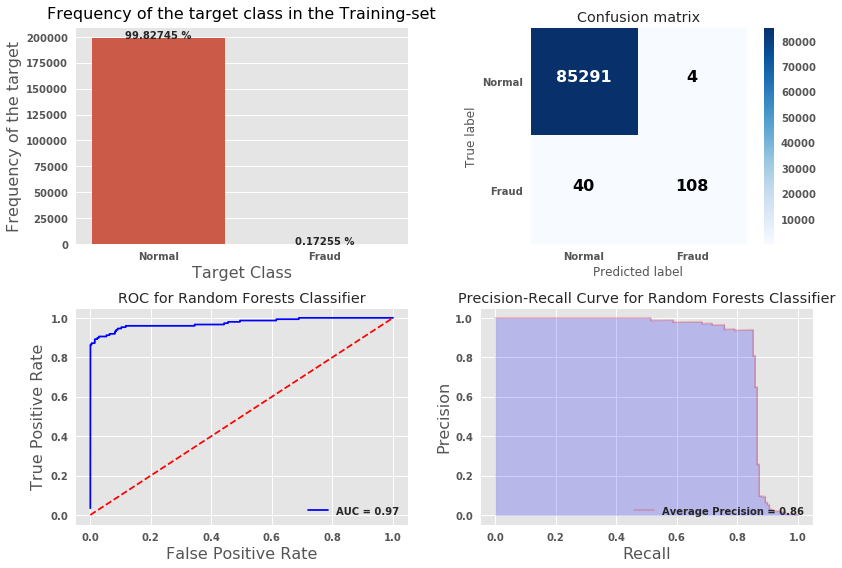

In [27]:
clf_rf=RandomForestClassifier(n_estimators=200,max_depth=10,n_jobs=5,random_state=0)
preds_rf=model_fitting_and_post_processing(clf_rf,X_train,Y_train,X_test,Y_test,clf_name='Random Forests',class_names=['Normal','Fraud'])

# 4.3) XGBoost

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


The accruacy of XGBoost on the Test set:  0.9995435553526912


/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))




----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85295
          1       0.96      0.77      0.85       148

avg / total       1.00      1.00      1.00     85443



--------------------------- Post-processed Plots --------------------------



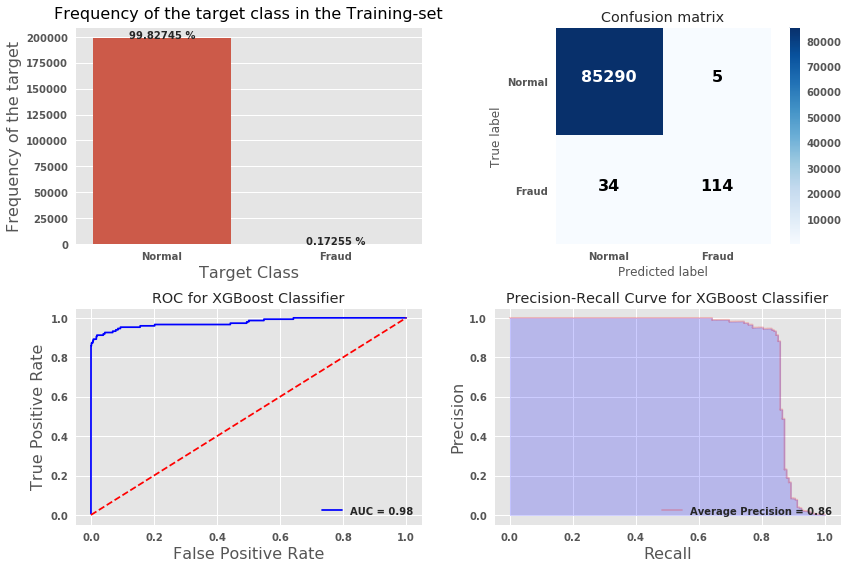

In [28]:
clf_xgbc=xgb.XGBClassifier(n_estimators=200,max_depth=5,random_state=0,n_jobs=-1)
preds_xgbc=model_fitting_and_post_processing(clf_xgbc,X_train,Y_train,X_test,Y_test,clf_name='XGBoost',class_names=['Normal','Fraud'])

# 6. Using Random Forests with ADASYN

In [45]:
os_ada=ADASYN(random_state=0)
X=data.drop(['Time','Class'],axis=1)
Y=data[['Class']]
Y.Class=Y.Class.map({'Fraud':1.0,'Normal':0.0})
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=0,stratify=Y.Class)

/home/namanda/anaconda3.6/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [46]:
xcols=X_train.columns.tolist()
X_oversampled,Y_oversampled=os_ada.fit_sample(X_train,Y_train.values.ravel())
data_resampled=pd.DataFrame(X_oversampled,columns=xcols)
data_resampled['Class']=Y_oversampled

In [47]:
X_rtrain=data_resampled.drop(['Class'],axis=1)
Y_rtrain=data_resampled[['Class']]

In [48]:
#Y_rtrain.head()

In [49]:
X_rtrain['Amount']=StandardScaler().fit_transform(X_rtrain['Amount'].values.reshape(-1,1))
X_test['Amount']=StandardScaler().fit_transform(X_test['Amount'].values.reshape(-1,1))

/home/namanda/anaconda3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [50]:
clf_rf=RandomForestClassifier(n_estimators=200,max_depth=10,n_jobs=8,random_state=0)

The accruacy of RF with ADASYN on the Test set:  0.9965942207085425


/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))




----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     85295
        1.0       0.32      0.82      0.46       148

avg / total       1.00      1.00      1.00     85443



--------------------------- Post-processed Plots --------------------------



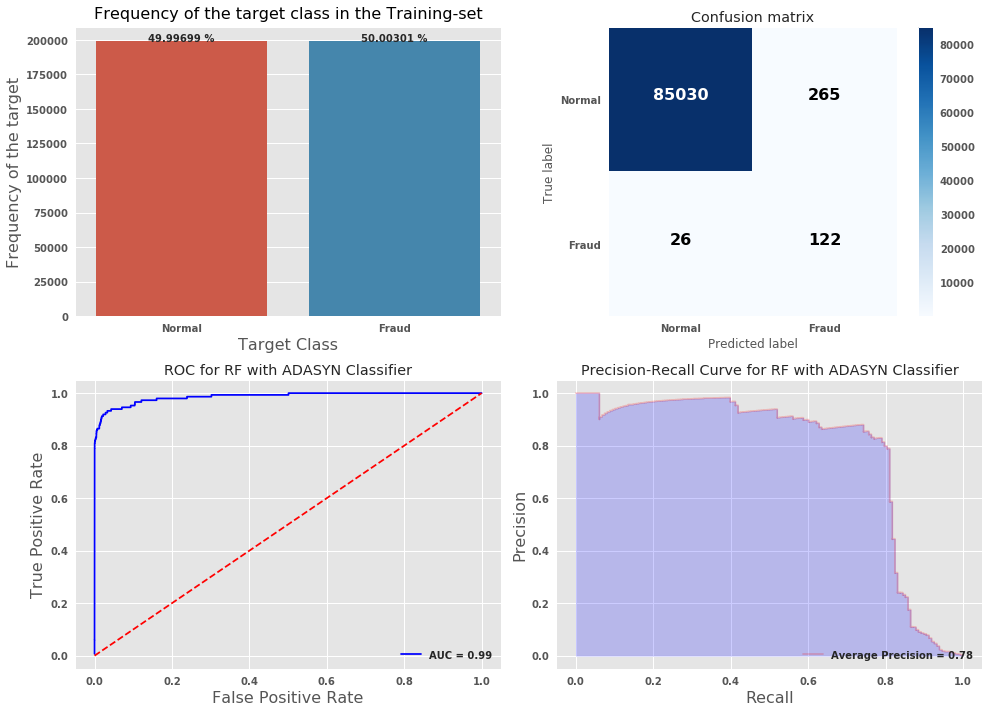

In [51]:
r_predictions=model_fitting_and_post_processing(clf_rf,X_rtrain,Y_rtrain,X_test,Y_test,clf_name='RF with ADASYN',class_names=['Normal','Fraud'])

# 6.2 XGBoost with ADASYN

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


The accruacy of XGBoost with ADASYN on the Test set:  0.984445770864787


/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))




----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

        0.0       1.00      0.98      0.99     85295
        1.0       0.09      0.91      0.17       148

avg / total       1.00      0.98      0.99     85443



--------------------------- Post-processed Plots --------------------------



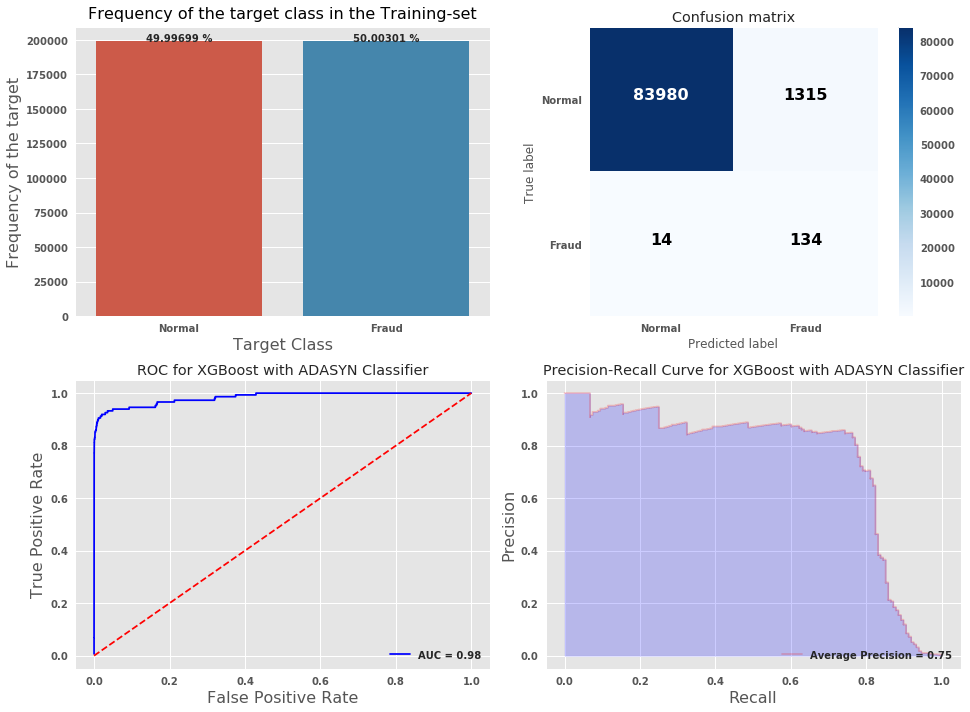

In [52]:
clf_xgbc=xgb.XGBClassifier(random_state=0,n_jobs=-1)
r_predictions=model_fitting_and_post_processing(clf_xgbc,X_rtrain,Y_rtrain,X_test,Y_test,clf_name='XGBoost with ADASYN',class_names=['Normal','Fraud'])

# 7. Cross-validation 

In [53]:
X_train.reset_index(inplace=True)
X_train.drop('index',axis=1,inplace=True)
Y_train.reset_index(inplace=True)
Y_train.drop('index',axis=1,inplace=True)

/home/namanda/anaconda3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/namanda/anaconda3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


## 7.1 CV with Random Forests

In [54]:
from sklearn.metrics import f1_score,make_scorer
scored=make_scorer(f1_score)

In [55]:
from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold(n_splits=5,random_state=0)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed: 14.6min finished




RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=442, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


The accruacy of Random Forests with CV on the Test set:  0.9993797034280163


/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))




----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     85295
        1.0       0.94      0.68      0.79       148

avg / total       1.00      1.00      1.00     85443



--------------------------- Post-processed Plots --------------------------



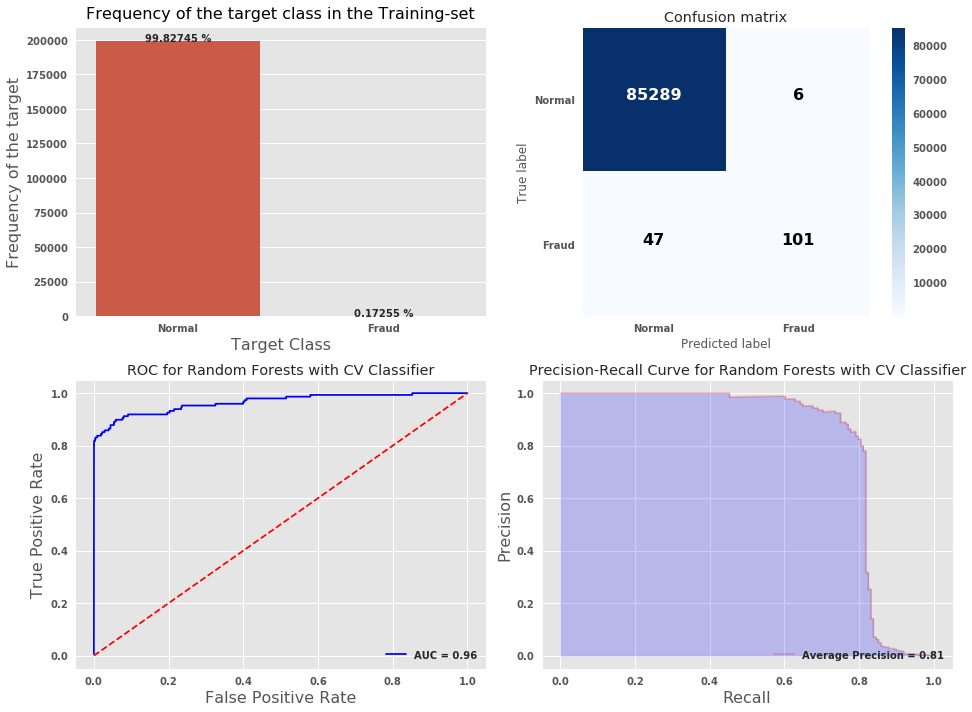

In [56]:
clf_rf=RandomForestClassifier(random_state=0)
params_rf = {"n_estimators": st.randint(0, 500),"max_depth": st.randint(4, 6),'min_samples_split':st.randint(2,6)}
rfrscv=RandomizedSearchCV(clf_rf, param_distributions=params_rf,n_iter=8,n_jobs=8,scoring=scored,cv=skf,verbose=True,random_state=0)
rf_predictions=model_fitting_and_post_processing(rfrscv,X_train,Y_train,X_test,Y_test,clf_name='Random Forests with CV',class_names=['Normal','Fraud'],cross_val=True)

## 7.2. ADACYN + CV with Random Forests

In [59]:
X_rtrain.reset_index(inplace=True)
X_rtrain.drop('index',axis=1,inplace=True)
Y_rtrain.reset_index(inplace=True)
Y_rtrain.drop('index',axis=1,inplace=True)

/home/namanda/anaconda3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed: 27.6min finished




RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=442, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


The accruacy of RF with ADASYN & CV on the Test set:  0.9932352562527065


/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/namanda/anaconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))




----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

        0.0       1.00      0.99      1.00     85295
        1.0       0.19      0.86      0.31       148

avg / total       1.00      0.99      1.00     85443



--------------------------- Post-processed Plots --------------------------



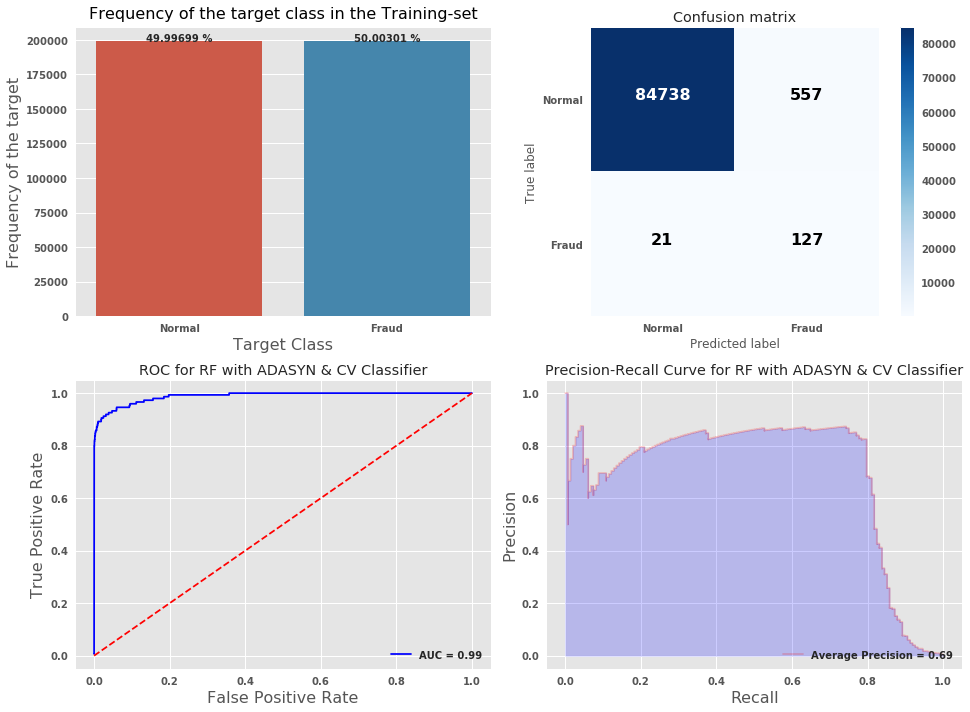

In [60]:
# with resampling
rf_predictions=model_fitting_and_post_processing(rfrscv,X_rtrain,Y_rtrain,X_test,Y_test,clf_name='RF with ADASYN & CV',class_names=['Normal','Fraud'],cross_val=True)

# 7.3  CV with XGBoost

In [64]:
params_xgb={'learning_rate':st.uniform(0.01,0.2), 'n_estimators':st.randint(200,500), 'subsample':[0.8,0.9], 'colsample_bytree':[0.8,0.9], 'max_depth' :st.randint(6,10)}

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  9.9min
[Parallel(n_jobs=8)]: Done  75 out of  75 | elapsed: 26.9min finished




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.13170485279893782,
       max_delta_step=0, max_depth=9, min_child_weight=1, missing=None,
       n_estimators=364, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)


The accruacy of XGBoost with CV on the Test set:  0.9995201479348805


----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     85295
        1.0       0.97      0.75      0.84       148

avg / total       1.00      1.00      1.00     85443



--------------------------- Post-processed Plots --------------------------



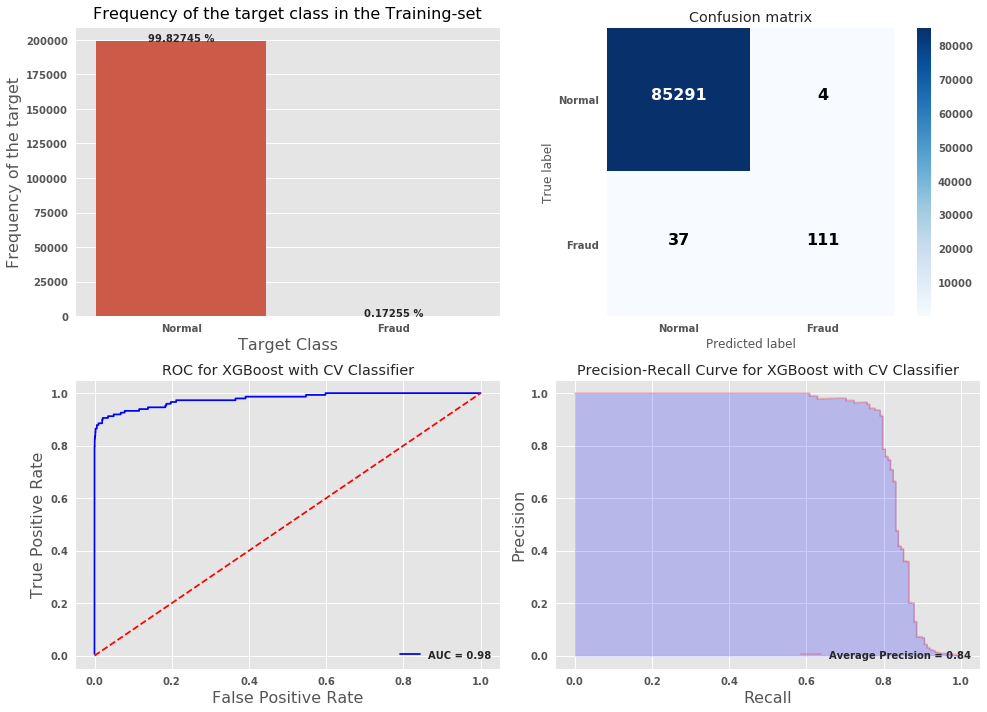

In [65]:
clf_xgb=xgb.XGBClassifier(random_state=0)
xgbrscv=RandomizedSearchCV(clf_xgb, param_distributions=params_xgb,n_iter=15,n_jobs=8,scoring=scored,cv=5,verbose=True)
xgb_predictions=model_fitting_and_post_processing(xgbrscv,X_train,Y_train,X_test,Y_test,clf_name='XGBoost with CV',class_names=['Normal','Fraud'],cross_val=True)

# Using SMOTE

In [98]:
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0) #   We are using SMOTE as the function for oversampling
X_oversampled,Y_oversampled=os.fit_sample(X_train,Y_train.values.ravel())

In [100]:
xcols=X_train.columns.tolist()
data_resampled=pd.DataFrame(X_oversampled,columns=xcols)
data_resampled['Class']=Y_oversampled

In [101]:
X_rtrain=data_resampled.drop(['Class'],axis=1)
Y_rtrain=data_resampled[['Class']]

In [102]:
X_rtrain['Amount']=StandardScaler().fit_transform(X_rtrain['Amount'].values.reshape(-1, 1))
#X_rtrain=pd.DataFrame(X_rtrain,columns=xcols)

In [103]:
X_rtrain.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-8.367621,7.402969,-5.114191,-2.966792,-0.985904,-1.660018,0.397816,1.008250,5.290976,9.315735,...,3.589299,-0.557927,0.349087,0.301734,0.662330,1.145939,-0.012273,1.513736,0.669504,-0.425216
1,-1.290662,0.764452,-0.169233,-1.688528,1.984718,-0.717210,1.667635,-0.228295,-0.959071,-0.679429,...,0.057620,0.138615,0.390374,-0.678774,0.292254,1.425865,0.265341,0.051405,0.103879,-0.205831
2,-0.606860,0.233923,2.633361,-0.155762,-0.328850,-0.070593,0.173023,0.113394,0.680147,-0.686651,...,-0.129287,0.007393,0.265045,-0.040615,0.406088,-0.498823,0.121851,-0.046840,-0.087259,-0.381923
3,1.374168,-0.330389,0.812971,-0.183112,-1.074771,-0.933788,-0.544238,-0.348237,0.614925,0.080408,...,0.078163,-0.134742,0.016793,0.002610,0.714527,0.536175,-0.307487,-0.003555,0.013024,-0.387931
4,-2.146505,-7.603113,-4.928224,1.449173,-2.083871,-0.984759,3.629816,-1.302973,-1.434148,-0.021909,...,4.009181,1.274986,-0.857670,-2.109682,0.169338,-0.322888,0.777822,-0.552258,0.304777,8.743299


In [104]:
clf_rf=RandomForestClassifier(random_state=0,n_estimators=200,n_jobs=8)

The accruacy of RF with SMOTE on the Test set:  0.9994967405170698


----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     85295
        1.0       0.91      0.79      0.84       148

avg / total       1.00      1.00      1.00     85443



--------------------------- Post-processed Plots --------------------------



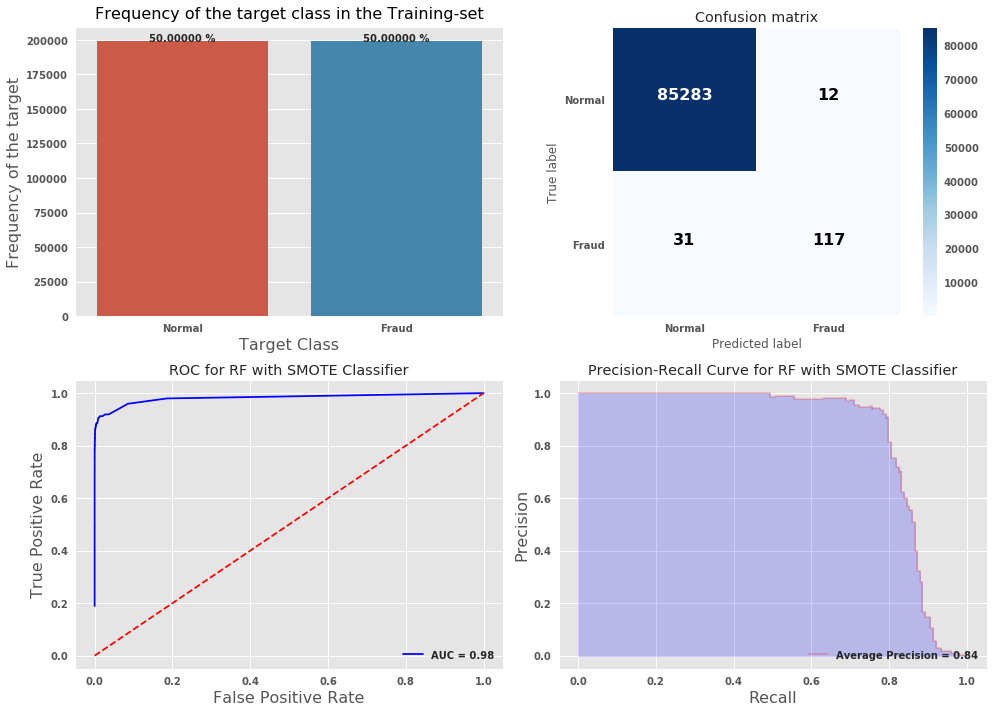

In [105]:
rf_predictions=model_fitting_and_post_processing(clf_rf,X_rtrain,Y_rtrain,X_test,Y_test,clf_name='RF with SMOTE',class_names=['Normal','Fraud'])

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed: 28.2min finished




RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=209, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


The accruacy of RF with SMOTE & CV on the Test set:  0.9981274065751436


----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     85295
        1.0       0.48      0.84      0.61       148

avg / total       1.00      1.00      1.00     85443



--------------------------- Post-processed Plots --------------------------



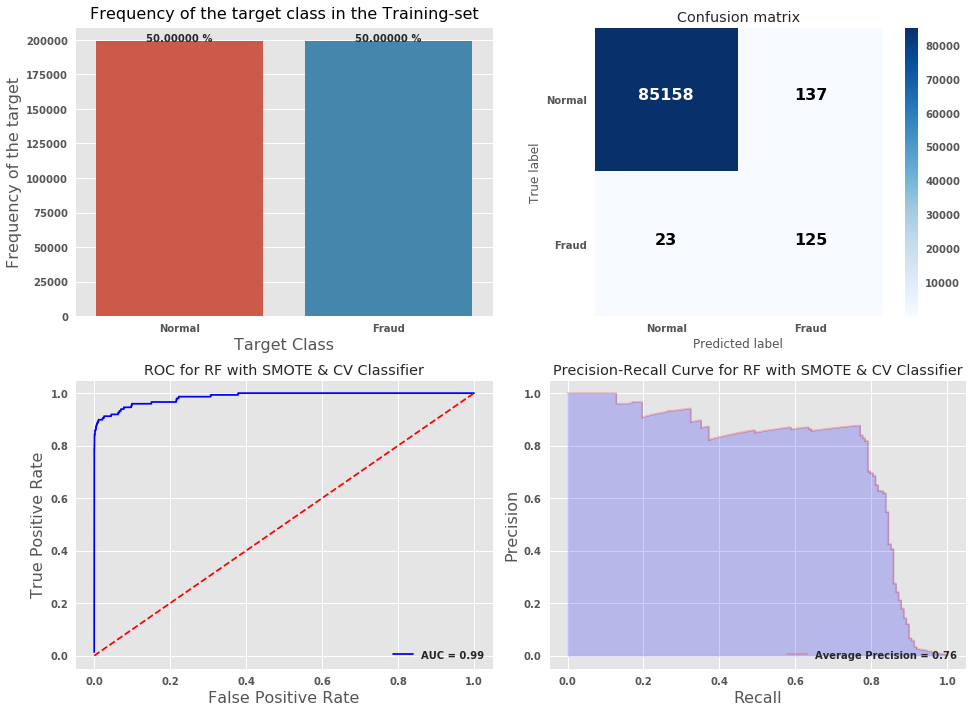

In [106]:
rf_predictions=model_fitting_and_post_processing(rfrscv,X_rtrain,Y_rtrain,X_test,Y_test,clf_name='RF with SMOTE & CV',class_names=['Normal','Fraud'],cross_val=True)

## 7.3) CV with XGBoost

In [75]:
params_xgb={'learning_rate':st.uniform(0.01,0.2), 'n_estimators':st.randint(80,500), 'subsample':[0.8,0.9], 'colsample_bytree':[0.8,0.9], 'max_depth' :st.randint(6,10)}

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.10702864847434629,
       max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
       n_estimators=478, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)




/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


The accruacy of XGBoost with CV on the Test set:  0.9995786664794073


/home/namanda/anaconda3.6/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)




----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.96      0.79      0.87        98

avg / total       1.00      1.00      1.00     56962



--------------------------- Post-processed Plots --------------------------



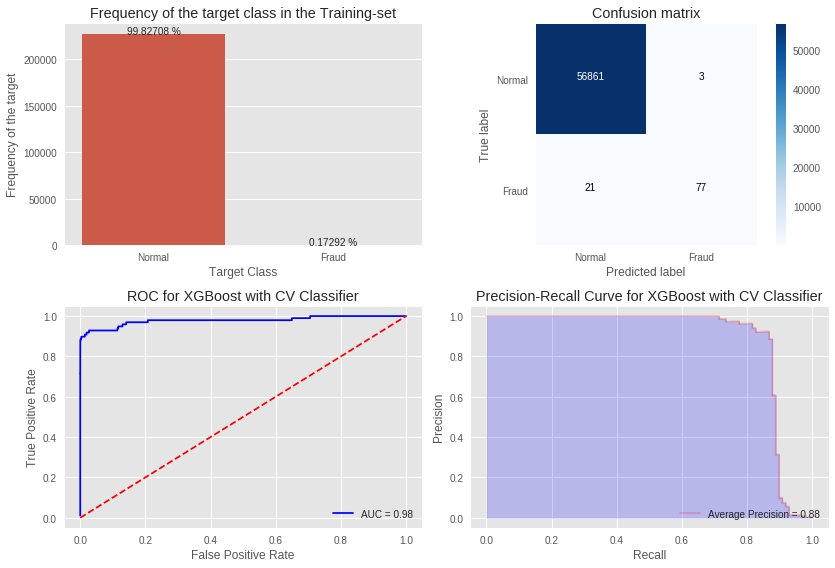

In [76]:
clf_xgb=xgb.XGBClassifier(random_state=0)
xgbrscv=RandomizedSearchCV(clf_xgb, param_distributions=params_xgb,n_iter=15,n_jobs=8,scoring=scored,cv=5,verbose=True)
xgb_predictions=model_fitting_and_post_processing(xgbrscv,X_train,Y_train,X_test,Y_test,clf_name='XGBoost with CV',class_names=['Normal','Fraud'],cross_val=True)

## 7.4 ADASYN+CV with XGBoost

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.12188920948198854,
       max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
       n_estimators=354, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.9)




/home/namanda/anaconda3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


The accruacy of XGBoost with ADASYN and CV on the Test set:  0.9919595519820231


/home/namanda/anaconda3.6/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)




----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

          0       1.00      0.99      1.00     56864
          1       0.16      0.84      0.26        98

avg / total       1.00      0.99      0.99     56962



--------------------------- Post-processed Plots --------------------------



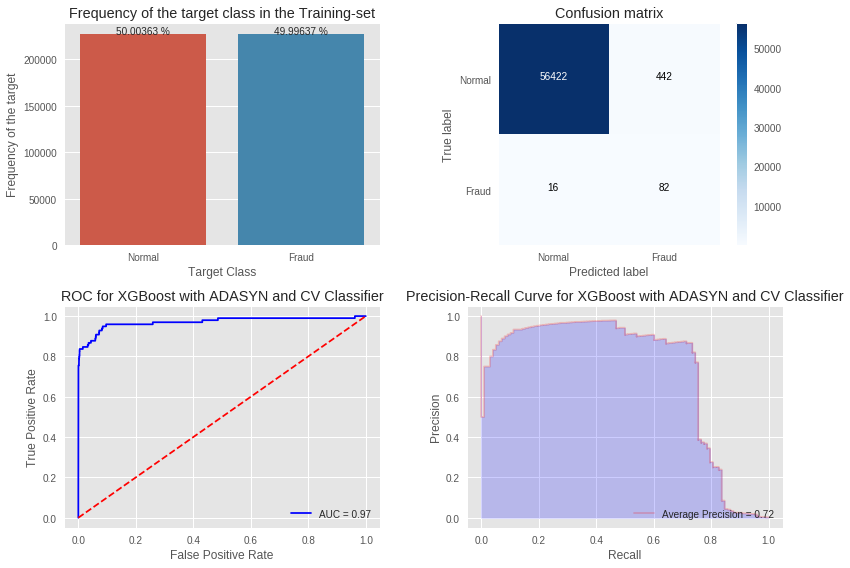

In [77]:
gbrscv=RandomizedSearchCV(clf_xgb, param_distributions=params_xgb,n_iter=15,n_jobs=8,scoring=scored,cv=5,verbose=True)
xgb_predictions=model_fitting_and_post_processing(xgbrscv,X_rtrain,Y_rtrain,X_test,Y_test,clf_name='XGBoost with ADASYN and CV',class_names=['Normal','Fraud'],cross_val=True)

# 8. Feature engineering

In [66]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,Normal
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,Normal
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,Normal
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,Normal
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,Normal


In [85]:
X=data.drop(['Time','Class'],axis=1)
Y=data[['Class']]

In [86]:
#Drop all of the features that have very similar distributions between the two types of transactions.
X = X.drop(['V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8'], axis =1)

In [87]:
#Based on the plots above, these features are created to identify values where fraudulent transaction are more common.
X['V1_'] = X.V1.map(lambda x: 1 if x < -3 else 0)
X['V2_'] = X.V2.map(lambda x: 1 if x > 2.5 else 0)
X['V3_'] = X.V3.map(lambda x: 1 if x < -4 else 0)
X['V4_'] = X.V4.map(lambda x: 1 if x > 2.5 else 0)
X['V5_'] = X.V5.map(lambda x: 1 if x < -4.5 else 0)
X['V6_'] = X.V6.map(lambda x: 1 if x < -2.5 else 0)
X['V7_'] = X.V7.map(lambda x: 1 if x < -3 else 0)
X['V9_'] = X.V9.map(lambda x: 1 if x < -2 else 0)
X['V10_'] = X.V10.map(lambda x: 1 if x < -2.5 else 0)
X['V11_'] = X.V11.map(lambda x: 1 if x > 2 else 0)
X['V12_'] = X.V12.map(lambda x: 1 if x < -2 else 0)
X['V14_'] = X.V14.map(lambda x: 1 if x < -2.5 else 0)
X['V16_'] = X.V16.map(lambda x: 1 if x < -2 else 0)
X['V17_'] = X.V17.map(lambda x: 1 if x < -2 else 0)
X['V18_'] = X.V18.map(lambda x: 1 if x < -2 else 0)
X['V19_'] = X.V19.map(lambda x: 1 if x > 1.5 else 0)
X['V21_'] = X.V21.map(lambda x: 1 if x > 0.6 else 0)

In [88]:
X_feat_train,X_feat_test,Y_feat_train,Y_feat_test = train_test_split(X,Y,test_size=0.3,random_state=0,stratify=Y.Class)

In [89]:
Y_feat_train.shape

(199364, 1)

In [90]:
X_feat_train.reset_index(inplace=True)
X_feat_train.drop('index',axis=1,inplace=True)
Y_feat_train.reset_index(inplace=True)
Y_feat_train.drop('index',axis=1,inplace=True)
X_feat_test.reset_index(inplace=True)
X_feat_test.drop('index',axis=1,inplace=True)
Y_feat_test.reset_index(inplace=True)
Y_feat_test.drop('index',axis=1,inplace=True)

In [91]:
X_feat_train['Amount']=StandardScaler().fit_transform(X_feat_train['Amount'].values.reshape(-1,1))
X_feat_test['Amount']=StandardScaler().fit_transform(X_feat_test['Amount'].values.reshape(-1,1))

In [93]:
Y_feat_train['Class']=Y_feat_train['Class'].map({'Fraud':1.0,'Normal':0.0})
Y_feat_test['Class']=Y_feat_test['Class'].map({'Fraud':1.0,'Normal':0.0})

In [94]:
params_xgb={'learning_rate':st.uniform(0.01,0.2), 'n_estimators':st.randint(200,500), 'subsample':[0.8,0.9], 'colsample_bytree':[0.8,0.9], 'max_depth' :st.randint(6,10)}

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed: 10.8min
[Parallel(n_jobs=8)]: Done  75 out of  75 | elapsed: 19.6min finished




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.16484673788684334,
       max_delta_step=0, max_depth=9, min_child_weight=1, missing=None,
       n_estimators=228, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)


The accruacy of XGBoost with CV on the Test set:  0.9995084442259752


----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     85295
        1.0       0.94      0.76      0.84       148

avg / total       1.00      1.00      1.00     85443



--------------------------- Post-processed Plots --------------------------



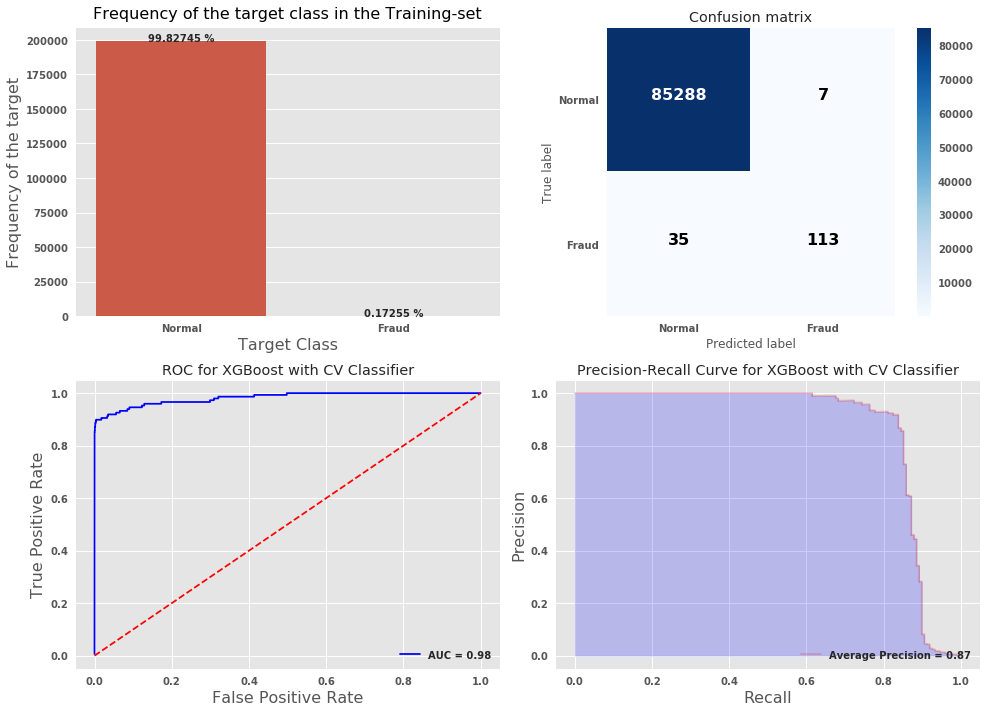

In [96]:
clf_xgb=xgb.XGBClassifier(random_state=0)
xgbrscv=RandomizedSearchCV(clf_xgb, param_distributions=params_xgb,n_iter=15,n_jobs=8,scoring=scored,cv=skf,verbose=True,random_state=0)
xgb_predictions=model_fitting_and_post_processing(xgbrscv,X_feat_train,Y_feat_train,X_feat_test,Y_feat_test ,clf_name='XGBoost with CV',class_names=['Normal','Fraud'],cross_val=True)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:  8.6min finished




RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=442, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


The accruacy of Random Forests with CV on the Test set:  0.9995084442259752


----------------------- Complete Classification Report -----------------------

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     85295
        1.0       0.95      0.76      0.84       148

avg / total       1.00      1.00      1.00     85443



--------------------------- Post-processed Plots --------------------------



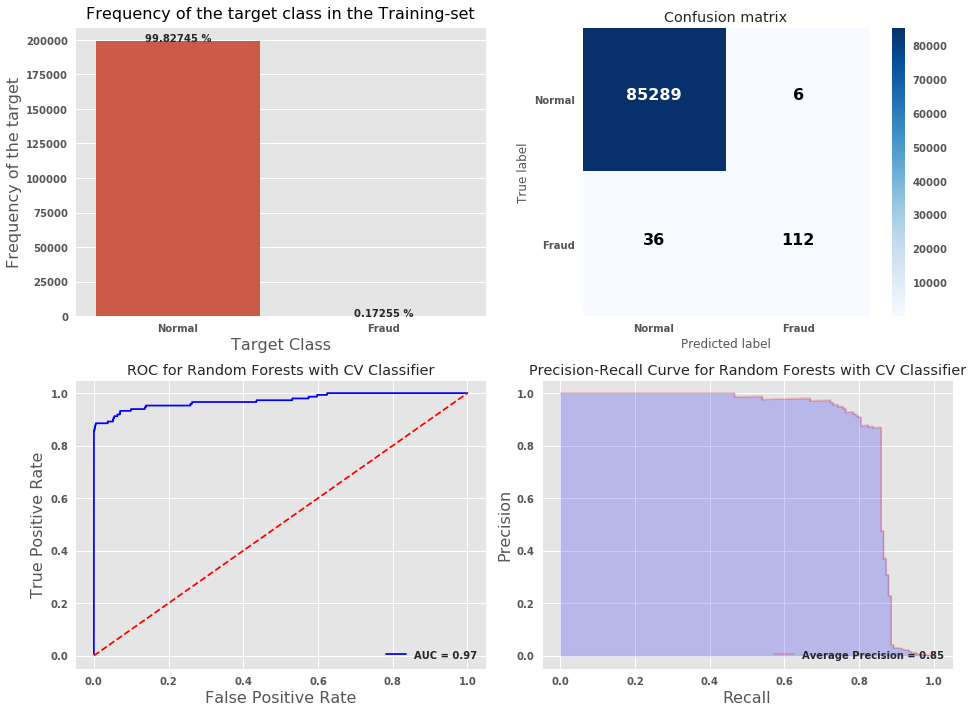

In [97]:
rf_predictions=model_fitting_and_post_processing(rfrscv,X_feat_train,Y_feat_train,X_feat_test,Y_feat_test,clf_name='Random Forests with CV',class_names=['Normal','Fraud'],cross_val=True)